The end goal of making these decision trees is to model the decision making process for each coach. To help us better understand the individual trees, we will start by making an "average" baseline tree that is built using data from every coach. This classification tree will predict whether or not a coach decides to go for it on a given 4th down scenario. It may help to try this using every 4th down play, as well as with some filters imposed on the data to extract more informative, higher leverage scenarios.

In [2]:
#| code-fold: true
#| code-summary: "Imports"

import pandas as pd
import seaborn as sns 
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import Counter
from sklearn.metrics import accuracy_score, precision_score, recall_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay

# Basic Data Exploration

We will take another look at our data just so we are familiar with the parameters we are working with.

In [3]:
#| code-fold: true
#| code-summary: "Summary Statistics"

df = pd.read_csv("data/df.csv").drop(["coach", "posteam_score", "defteam_score"], axis=1)
pd.set_option('display.float_format', '{:.2f}'.format)

summary = pd.DataFrame({"dtypes": df.dtypes, "min" : df.min(), "mean" : df.mean(), "max" : df.max()})
print(summary)

                         dtypes    min   mean     max
game_half                 int64   1.00   1.50    2.00
half_seconds_remaining    int64   1.00 813.95 1789.00
ydstogo                   int64   1.00   7.79   46.00
yardline_100              int64   1.00  49.85   99.00
go_boost                float64 -45.55  -0.55   48.80
wp_fail                 float64   0.00   0.42    1.00
wp_succeed              float64   0.00   0.55    1.00
wp                      float64   0.00   0.48    1.00
fg_make_prob            float64   0.00   0.30    0.99
miss_fg_wp              float64   0.00   0.41    1.00
make_fg_wp              float64   0.00   0.52    1.00
punt_wp                 float64   0.00   0.45    1.00
score_diff                int64 -49.00  -1.02   49.00
go                        int64   0.00   0.16    1.00


In [4]:
#| code-fold: true
#| code-summary: "Count Scenarios"

count_0 = sum(df["go"] == 0)
count_1 = sum(df["go"] == 1)
total = count_0 + count_1

print("Number of not go points:", count_0, round(count_0/total, 3))
print("Number of go points:", count_1, round(count_1/total, 3))

Number of not go points: 23476 0.842
Number of go points: 4418 0.158


We have many more "go" points than "not go" points, which makes sense considering what we have learned about our data throughout this whole process. It is useful to know that "go" scenarios make up 84.2% of plays and "not go" scenarios make up only 15.8% of plays.

# Baseline Model

We will create a random classifier to have a baseline model to compare our actual model to. This will be a binary classifier with probabilities equal to those seen in our actual, data.

In [5]:
#| code-fold: true
#| code-summary: Generate Data

# code taken from random classifier lab demo

def generate_label_data(class_labels, weights,N=10000):

    y=random.choices(class_labels, weights = weights, k = N)
    print("-----GENERATING DATA-----")
    print("unique entries:",Counter(y).keys())  
    print("count of labels:",Counter(y).values()) # counts the elements' frequency
    print("probability of labels:",np.fromiter(Counter(y).values(), dtype=float)/len(y)) # counts the elements' frequency
    return y

baseline = generate_label_data([0,1], [0.842, 0.158], 27894)


-----GENERATING DATA-----
unique entries: dict_keys([0, 1])
count of labels: dict_values([23492, 4402])
probability of labels: [0.84218828 0.15781172]


In [6]:
#| code-fold: true
#| code-summary: Random Classifier

# code taken from random classifier lab demo

def random_classifier(y_data):
    ypred=[];
    max_label=np.max(y_data); #print(max_label)
    for i in range(0,len(y_data)):
        ypred.append(int(np.floor((max_label+1)*np.random.uniform(0,1))))

    print("-----RANDOM CLASSIFIER-----")
    print("count of prediction:",Counter(ypred).values()) # counts the elements' frequency
    print("probability of prediction:",np.fromiter(Counter(ypred).values(), dtype=float)/len(y_data)) # counts the elements' frequency
    print("accuracy",round(accuracy_score(y_data, ypred), 3))
    print("percision, recall, fscore,",precision_recall_fscore_support(y_data, ypred))

random_classifier(baseline)

-----RANDOM CLASSIFIER-----
count of prediction: dict_values([14047, 13847])
probability of prediction: [0.503585 0.496415]
accuracy 0.499
percision, recall, fscore, (array([0.84321514, 0.15882395]), array([0.49702026, 0.50681508]), array([0.62540507, 0.24185593]), array([23492,  4402]))


We can use these statistics to determine if models we create later are performing well, as if they are doing better than this baselien model that is a good sign.


# Isolate Inputs/Output

In [7]:
# Split data into features and target
X = df.loc[:,["game_half", "half_seconds_remaining", "ydstogo", "yardline_100", "score_diff"]]
Y = df["go"]

Here we are selecting the columns we want to use to train our model. `go` is our target variable, so it will be the only variable in our `Y` table. I have decided to have our `X` table only include features that are easily accessible by simply observing a game state. Variables such as `wp` (win probability) or `fg_make_prob` are obtained through calculation, not simple observation. The decision to go for it or not often needs to be made quickly and efficently, meaning those probabilities may not be considered as they are too complicated to come up with on the fly. Variables such as `game_half` or `score_diff` can be determined just by looking at the scoreboard, and in my opinion would result in a decision tree more representative of a real coach's thought process when they have to run through one of these decisions in real time. However, with the advances in technology and statistics in the game of football, these probability based variables could be accessed in real time, by coaches. It would be worth making a tree that does include these variables, but for now I will stick with variables that can be obtained simply by observing the current game state. 

These variables are: `game_half`, `half_seconds_remaining`, `ydstogo`, `yardline_100`, and `score_diff`.

In [8]:
#| code-fold: true
#| code-summary: "Train/Test Split"

# Split data into train and test sets
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=621)

# Check size of train and test splits
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x_train shape: (22315, 5)
y_train shape: (22315,)
x_test shape: (5579, 5)
y_test shape: (5579,)


Here we split our data into train and test sets according to an 80/20 split. We have 5 feature variables and 1 target variable.

# Training the Model

In [9]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(random_state = 621, max_depth = 4, min_samples_leaf = 100)
model = clf.fit(x_train.values, y_train)

For now we will have a `max_depth` parameter of 4 and a `min_samples_leaf` parameter of 100, though these hyperparameters will be tuned later.

# Check the Model

------TEST------
ACCURACY:  0.886
NEGATIVE RECALL (Y=0):  0.958
NEGATIVE PRECISION (Y=0):  0.91
POSITIVE RECALL (Y=1):  0.517
POSITIVE PRECISION (Y=1):  0.709
[[4468  195]
 [ 442  474]]


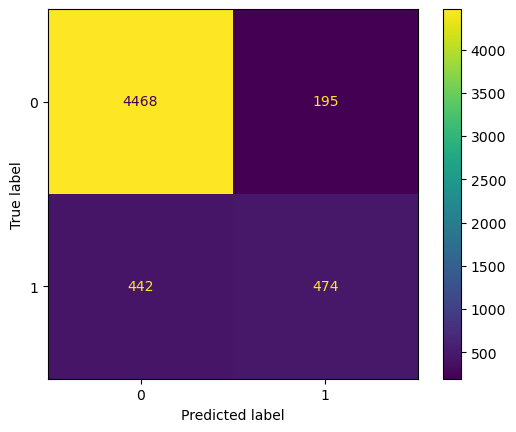

In [10]:
#| code-fold: true
#| code-summary: "Generate Confusion Matrices"

yp_train = model.predict(x_train.values)
yp_test = model.predict(x_test.values)

def confusion_plot(y_data, y_pred):
    cm = confusion_matrix(y_data, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=model.classes_)
    print("ACCURACY: ", round(accuracy_score(y_data, y_pred), 3))
    print("NEGATIVE RECALL (Y=0): ", round(recall_score(y_data, y_pred, pos_label=0), 3))
    print("NEGATIVE PRECISION (Y=0): ", round(precision_score(y_data, y_pred, pos_label=0), 3))
    print("POSITIVE RECALL (Y=1): ", round(recall_score(y_data, y_pred, pos_label=1), 3))
    print("POSITIVE PRECISION (Y=1): ", round(precision_score(y_data, y_pred, pos_label=1), 3))
    print(cm)
    disp.plot()
    plt.show()
    
# print("------TRAINING------")
# confusion_plot(y_train,yp_train)

print("------TEST------")
confusion_plot(y_test,yp_test)

Negative recall and precision are very good, meaning our model is good at predicting when coaches will not go for it, which makes sense. Positive recall and precision, on the other hand, are not nearly as good. It is much harder to predict when coaches will go for it than when they will not go for it. Our accuracy of 0.886 shows that we are clearly outperforming our baseline model, this is a very good model.

# Visualize the Tree

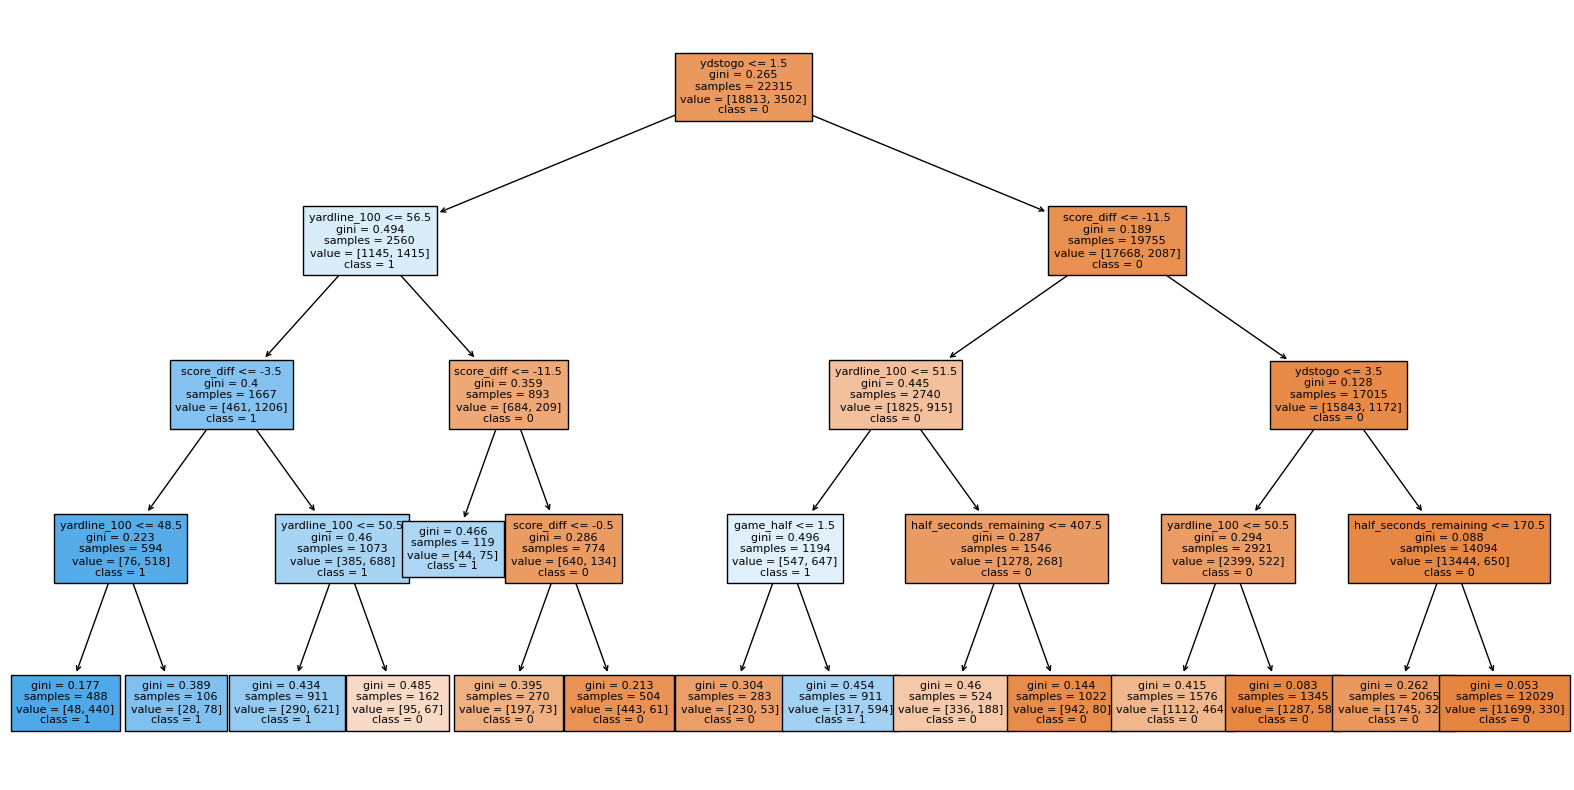

In [11]:
#| code-fold: true
#| code-summary: Tree Visualization Code

fig = plt.figure(figsize=(20,10))
_ = tree.plot_tree(model,
                feature_names=X.columns,
                class_names=[str(class_) for class_ in Y.unique()], 
                filled=True,
                fontsize = 8)
plt.show()

To interpret this tree, first look at the feature chosen on each level. The higher the feature on the tree, the more important it is in making a decision. According to this decision tree made with data from every coach in the last 6 seasons, the most important variable in determining whether or not to go for it is the yards needed to get the first down, `ydstogo`. The decsion point is set at 1, where if the yards to go is 1 or less, take a left. If the yards to go is more than 1, take a right.

Let's say there is only 1 yard to go, meaning you arrive at the node labelled `yardline_100 <= 56.5`. If you chose to stop here, the average coach would go for it, though it is close. The counts of each class are displayed in each node and in this node we observe that out of the 2,560 4th down scenarios with 1 yard to go, the coach decided to go for it 1,415 times and decided to not go for it 1,145 times, independent of all other variables. The next variable they would look at is `yardline_100`. If they are 56 yards or closer to the end zone (essentially right around midfield), they would take a left. If not, take a right. This process continues until a leaf is reached.

We can see some variables come up more than others, meaning they are more important in making deicsions. This makes sense when thinking about this tree as an actual coach's deicsion making process. Let's return to the scenerio detailed in the High-Leverage Scenarios tab and evaluate Vic Fangio's situation as an average NFL head coach. More context is provided on that tab, so here we will keep it simple and only go over the relevant parameters to our model. Going over those parameters one more time:

`game_half`: 2

`half_seconds_remaining`: 210

`ydstogo`: 5

`yardline_100`: 43

`score_diff`: 1

We can use the `dtreeviz` library to observe the path this particular instance takes through our tree.

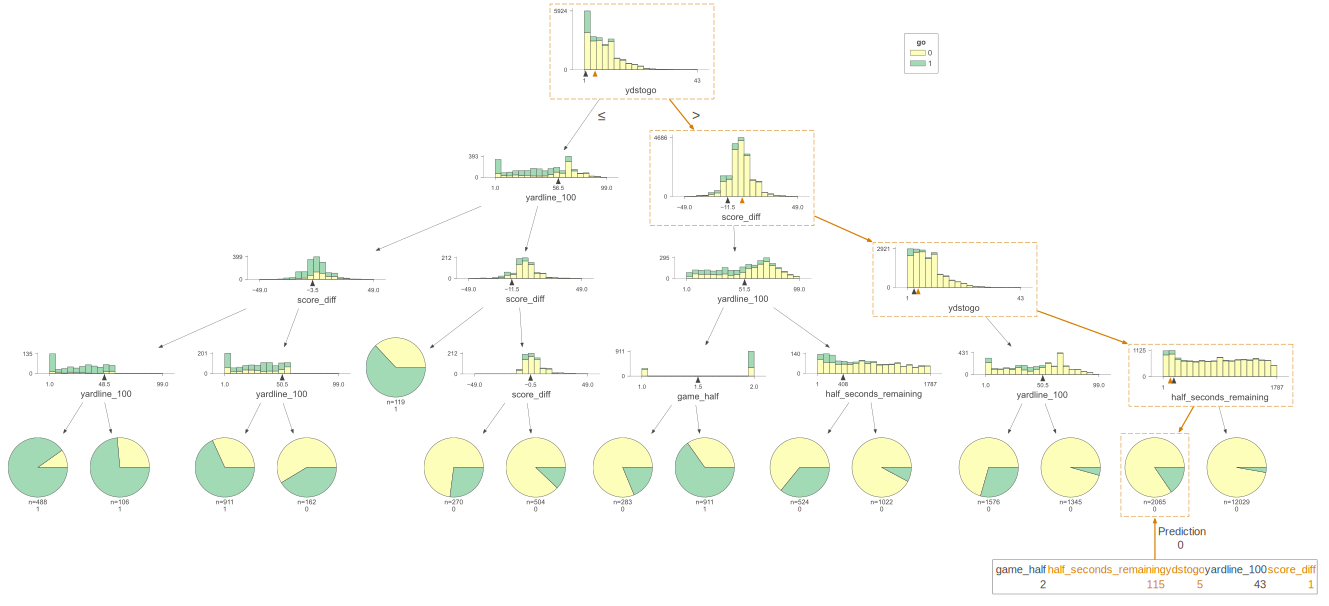

In [17]:
#| code-fold: true
#| code-summary: Tree Instance

import dtreeviz

viz_model = dtreeviz.model(clf,
                           X_train=x_train, y_train=y_train,
                           feature_names=["game_half", "half_seconds_remaining", "ydstogo", "yardline_100", "score_diff"],
                           target_name="go", class_names=[0, 1])

instance = X.iloc[13590]
viz_model.view(x = instance)

Looking at just the nodes that our sitaution encountered and the importance of each feature:

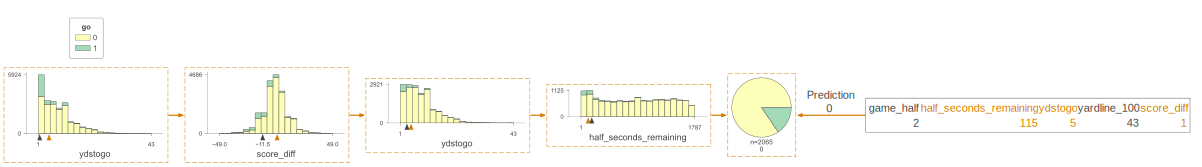

In [18]:
#| code-fold: true
#| code-summary: "Nodes"

viz_model.view(x=instance, show_just_path=True, orientation = "LR")

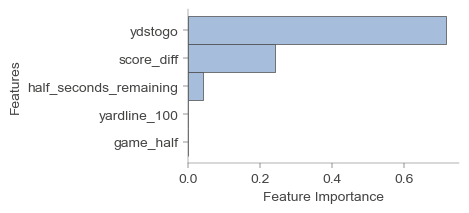

In [19]:
#| code-fold: true
#| code-summary: "Features"

viz_model.instance_feature_importance(x = instance, figsize=(3.5,2))

These plots show us a few interesting things. The average coach, placed in this situation, would not even consider where they were on the field, or what half it was. The most important thing to them would be how many yards needed to pick up a first down, followed by the score, and then followed by the time left in the half. Most coaches would not have gone for it in this situation, which is exactly what Vic Fangio did. 

# Hyper-parameter tuning
## `max_depth`

In [20]:
#| code-fold: true
#| code-summary: "`max_depth` Tuning"

test_results=[]
train_results=[]

for num_layer in range(1,10):
    model = tree.DecisionTreeClassifier(max_depth=num_layer)
    model = model.fit(x_train, y_train)

    yp_train=model.predict(x_train)
    yp_test=model.predict(x_test)

    # print(y_pred.shape)
    test_results.append([num_layer,
    accuracy_score(y_test, yp_test),
    recall_score(y_test, yp_test,pos_label=0),
    recall_score(y_test, yp_test,pos_label=1)])
    
    train_results.append([num_layer,
    accuracy_score(y_train, yp_train),
    recall_score(y_train, yp_train,pos_label=0),
    recall_score(y_train, yp_train,pos_label=1)])

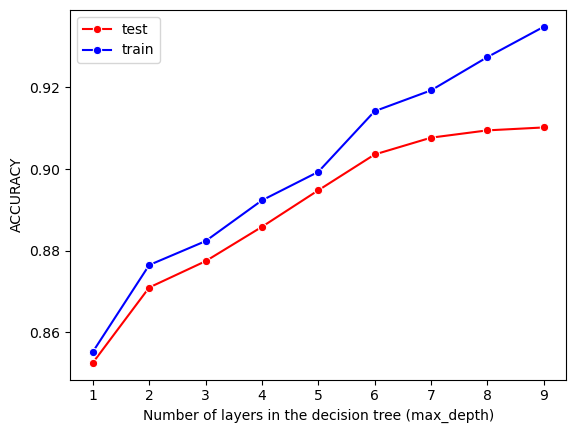

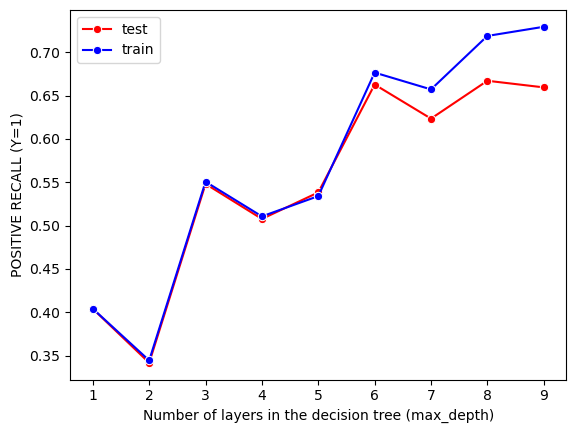

In [21]:
#| code-fold: true
#| code-summary: "`max_depth` Plots"

plt.cla()
ax = sns.lineplot(x=np.asarray(test_results)[:,0],
                y=np.asarray(test_results)[:,1],
                color="red",
                marker="o",
                label="test")
sns.lineplot(x=np.asarray(train_results)[:,0],
                y=np.asarray(train_results)[:,1],
                color="blue",
                marker="o",
                label="train")
ax.set(xlabel="Number of layers in the decision tree (max_depth)", ylabel="ACCURACY")
plt.legend()
plt.show()

plt.cla()
ax = sns.lineplot(x=np.asarray(test_results)[:,0],
                y=np.asarray(test_results)[:,3],
                color="red",
                marker="o",
                label="test")
sns.lineplot(x=np.asarray(train_results)[:,0],
                y=np.asarray(train_results)[:,3],
                color="blue",
                marker="o",
                label="train")
ax.set(xlabel="Number of layers in the decision tree (max_depth)", ylabel="POSITIVE RECALL (Y=1)")
plt.legend()
plt.show()

6 layers is the optimal `max_depth` parameter.

## `min_samples_leaf`

In [22]:
#| code-fold: true
#| code-summary: "`min_samples` Tuning"

test_results=[]
train_results=[]

for samples in range(1,1000):
    model = tree.DecisionTreeClassifier(max_depth=6, min_samples_leaf = samples)
    model = model.fit(x_train, y_train)

    yp_train=model.predict(x_train)
    yp_test=model.predict(x_test)

    # print(y_pred.shape)
    test_results.append([samples,
    accuracy_score(y_test, yp_test),
    recall_score(y_test, yp_test,pos_label=0),
    recall_score(y_test, yp_test,pos_label=1)])
    
    train_results.append([samples,
    accuracy_score(y_train, yp_train),
    recall_score(y_train, yp_train,pos_label=0),
    recall_score(y_train, yp_train,pos_label=1)])

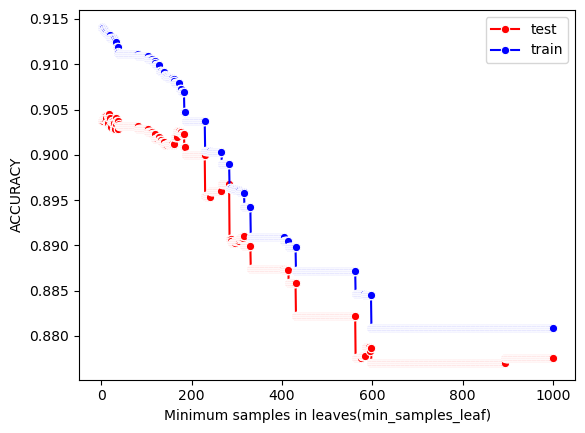

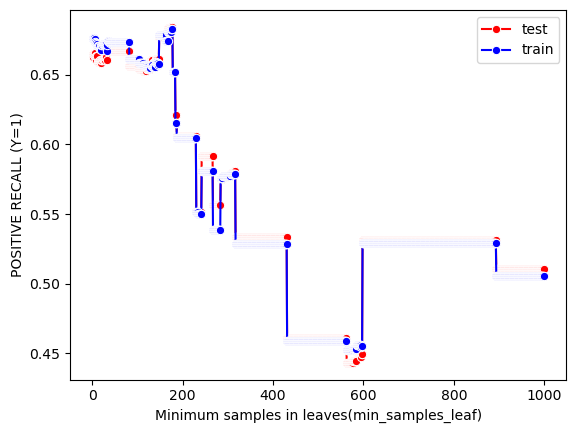

2

In [26]:
#| code-fold: true
#| code-summary: "`min_samples` Plots"

plt.cla()
ax = sns.lineplot(x=np.asarray(test_results)[:,0],
                y=np.asarray(test_results)[:,1],
                color="red",
                marker="o",
                label="test")
sns.lineplot(x=np.asarray(train_results)[:,0],
                y=np.asarray(train_results)[:,1],
                color="blue",
                marker="o",
                label="train")
ax.set(xlabel="Minimum samples in leaves(min_samples_leaf)", ylabel="ACCURACY")
plt.legend()
plt.show()

plt.cla()
ax = sns.lineplot(x=np.asarray(test_results)[:,0],
                y=np.asarray(test_results)[:,3],
                color="red",
                marker="o",
                label="test")
sns.lineplot(x=np.asarray(train_results)[:,0],
                y=np.asarray(train_results)[:,3],
                color="blue",
                marker="o",
                label="train")
ax.set(xlabel="Minimum samples in leaves(min_samples_leaf)", ylabel="POSITIVE RECALL (Y=1)")
plt.legend()
plt.show()

Around 175 samples is a good minimum for `min_samples_leaf`.

## Visualize Best Tree

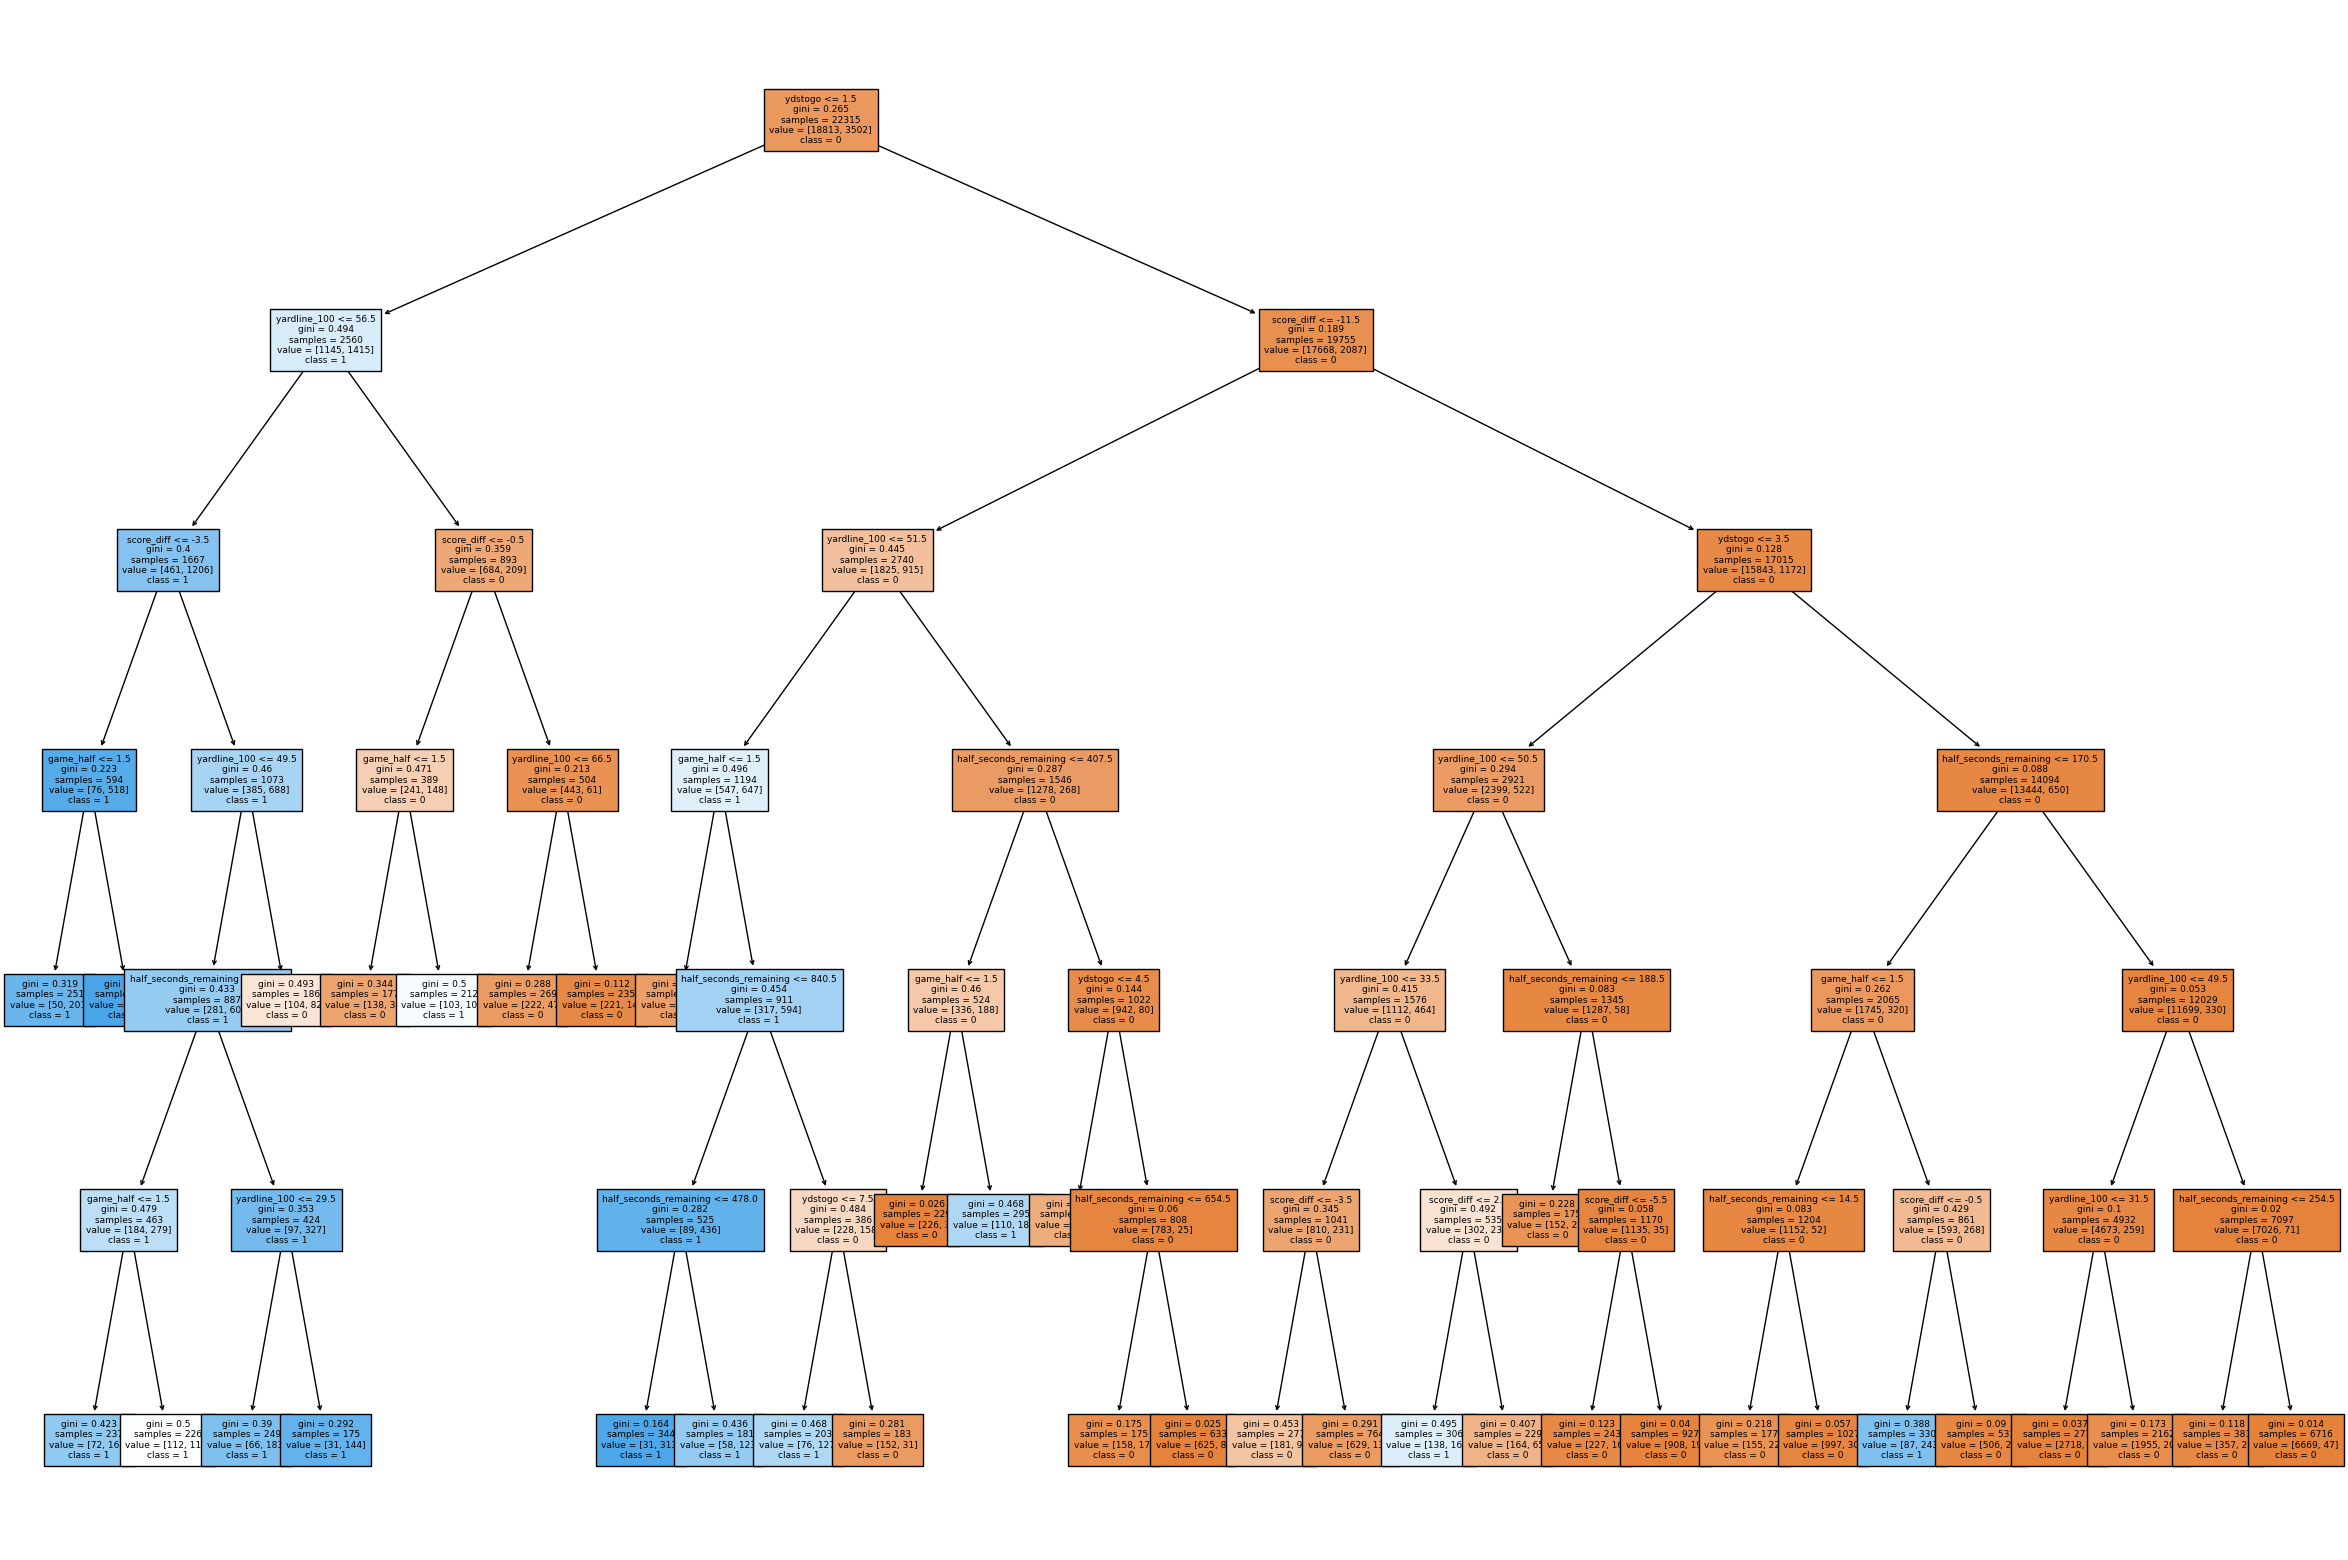

In [43]:
#| code-fold: true

best_clf = tree.DecisionTreeClassifier(random_state = 621, max_depth = 6, min_samples_leaf = 175)
best_model = best_clf.fit(x_train.values, y_train)

fig = plt.figure(figsize=(30,20))
_ = tree.plot_tree(best_model,
                feature_names=X.columns,
                class_names=[str(class_) for class_ in Y.unique()], 
                filled=True,
                fontsize = 6.5)
plt.show()

Increasing `max_depth` made this tree larger and therefore harder to visualize. Let's run through the scenario we looked at previously and see what changes with this new, optimized tree.

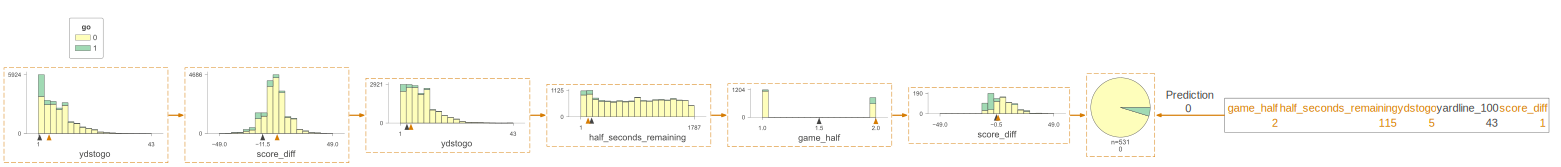

In [44]:
#| code-fold: true
#| code-summary: "Nodes"

viz_model = dtreeviz.model(best_clf,
                           X_train=x_train, y_train=y_train,
                           feature_names=["game_half", "half_seconds_remaining", "ydstogo", "yardline_100", "score_diff"],
                           target_name="go", class_names=[0, 1])
viz_model.view(x=instance, show_just_path=True, orientation = "LR")

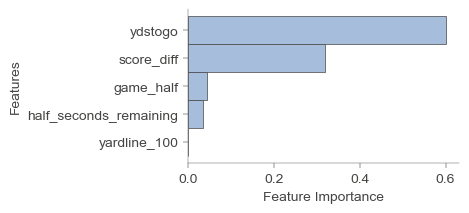

In [45]:
#| code-fold: true
#| code-summary: "Features"

viz_model.instance_feature_importance(x = instance, figsize=(3.5,2))

The main difference here is that `game_half` played a role in making this decision, even more so than `half_seconds_remaining`, which is interesting considering that it did not come into play in the previous scenario. In this tree, this situaion finds itself in a leaf where even more scenarios resulted in the coach not going for it. 

Optimized tree metrics:

ACCURACY:  0.902
NEGATIVE RECALL (Y=0):  0.945
NEGATIVE PRECISION (Y=0):  0.938
POSITIVE RECALL (Y=1):  0.684
POSITIVE PRECISION (Y=1):  0.711
[[4408  255]
 [ 289  627]]


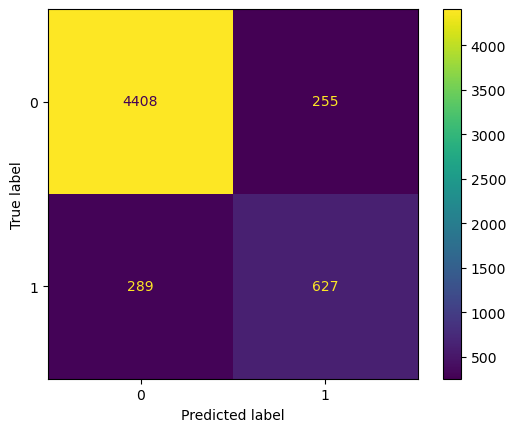

In [49]:
#| code-fold: true

yp_train = best_model.predict(x_train.values)
yp_test = best_model.predict(x_test.values)

confusion_plot(y_test, yp_test)